In [3]:
import argparse
import os
import torch
import numpy as np
import random
import pandas as pd


from exp.exp_NRU_RBN import Exp_NRU_RBN
%matplotlib inline

parser = argparse.ArgumentParser(description='NRU_RBN Forecasting')

parser.add_argument('--model', type=str, default='NRU_RBN',help='model of experiment, options: [NRU_RBN]')
value="ETTh1" #ETTh1,ETTh2,electrans,weather,exchange,BTC
parser.add_argument('--data', type=str, default=value, help='data')
parser.add_argument('--root_path', type=str, default='datasets', help='root path of the data file')
parser.add_argument('--data_path', type=str, default=value+'.csv', help='data file')    #electrans.csv
parser.add_argument('--features', type=str, default='MS', help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h', help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default= 'model_parameters/'+value, help='location of model checkpoints')

parser.add_argument('--seq_len', type=int, default=(90)+1, help='input sequence length of Informer encoder')
parser.add_argument('--label_len', type=int, default=90, help='start token length of Informer decoder')
parser.add_argument('--pred_len', type=int, default=30, help='prediction sequence length')
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

parser.add_argument('--enc_in', type=int, default=3, help='encoder input size')
parser.add_argument('--dec_in', type=int, default=3, help='decoder input size')
parser.add_argument('--c_out', type=int, default=3, help='output size')
parser.add_argument('--d_model', type=int, default=256, help='dimension of model')
parser.add_argument('--d_ff', type=int, default=256, help='dimension of fcn')
parser.add_argument('--padding', type=int, default=0, help='padding type')
parser.add_argument('--distil', action='store_false', help='whether to use distilling in encoder, using this argument means not using distilling', default=False)
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')
parser.add_argument('--embed', type=str, default='timeF', help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu',help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder',default=False)
parser.add_argument('--do_predict', action='store_false', help='whether to predict unseen future data')
parser.add_argument('--mix', action='store_false', help='use mix attention in generative decoder', default=True)
parser.add_argument('--cols', type=str, nargs='+', help='certain cols from the data files as the input features')
parser.add_argument('--num_workers', type=int, default=32, help='data loader num workers')
parser.add_argument('--itr', type=int, default=3, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=20, help='train epochs')
parser.add_argument('--batch_size', type=int, default=128, help='batch size of train input data')
parser.add_argument('--patience', type=int, default=2, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test',help='exp description')
parser.add_argument('--loss', type=str, default='mse',help='loss function')
parser.add_argument('--lradj', type=str, default='type1',help='adjust learning rate')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)
parser.add_argument('--inverse', action='store_true', help='inverse output data', default=False)
parser.add_argument('--likeloss', action='store_true', help='likeloss', default=True)
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3',help='device ids of multile gpus')
parser.add_argument('--lossregularizer', type=bool, default=True, help='Use loss regularizer')


args = parser.parse_args("")
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

data_parser = {
    'exchange':{'data':'exchange.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1],'freqin':'d'},
    'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1],'freqin':'h'},
    'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1],'freqin':'h'},
    'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1],'freqin':'h'},
    'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1],'freqin':'h'},
    'WTH':{'data':'WTH.csv','T':'WetBulbCelsius','M':[12,12,12],'S':[1,1,1],'MS':[12,12,1],'freqin':'h'},
    'weather':{'data':'weather.csv','T':'WetBulbCelsius','M':[12,12,12],'S':[1,1,1],'MS':[12,12,1],'freqin':'h'},
    'electrans':{'data':'electrans.csv','T':'MT_24','M':[316,316,316],'S':[1,1,1],'MS':[316,316,1],'freqin':'h'},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]
    args.freq=data_info['freqin']

args.detail_freq = args.freq
args.freq = args.freq[-1:]
args.likeloss =args.lossregularizer
print('Args in experiment:')
print(args)
torch.cuda.empty_cache()
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

Args in experiment:
Namespace(model='NRU_RBN', data='ETTh1', root_path='datasets', data_path='ETTh1.csv', features='MS', target='OT', freq='h', checkpoints='model_parameters/ETTh1', seq_len=91, label_len=90, pred_len=30, enc_in=7, dec_in=7, c_out=1, d_model=256, d_ff=256, padding=0, distil=False, dropout=0.05, embed='timeF', activation='gelu', output_attention=False, do_predict=True, mix=True, cols=None, num_workers=32, itr=3, train_epochs=20, batch_size=128, patience=2, learning_rate=0.0001, des='test', loss='mse', lradj='type1', use_amp=False, inverse=False, likeloss=True, use_gpu=True, gpu=0, use_multi_gpu=False, devices='0,1,2,3', lossregularizer=True, detail_freq='h')


Use GPU: cuda:0
Num_params : 3432394 
>>>>>>>start training : id0_mNRU_RBN_dETTh1_ftMS_sl91_ll90_pl30_dm256_df256_ebtimeF_0_lossreg_True>>>>>>>>>>>>>>>>>>>>>>>>>>
train 12074
val 2493
test 2493
No File, Train new


100%|██████████| 94/94 [00:51<00:00,  1.83it/s]


Epoch: 1 cost time: 51.35798931121826


100%|██████████| 19/19 [00:05<00:00,  3.42it/s]


vali_CRPS_mean:0.35560307 vali_CRPS_var:0.00031907993


100%|██████████| 19/19 [00:05<00:00,  3.47it/s]


test_CRPS_mean:0.2338941 test_CRPS_var:0.008586969
Epoch: 1, Steps: 94 | Train Loss: 0.8160372 Vali Loss: 0.6574904 Test Loss: 0.7570128
Validation loss decreased (inf --> 0.657490).  Saving model ...


100%|██████████| 94/94 [00:50<00:00,  1.85it/s]


Epoch: 2 cost time: 50.767690658569336


100%|██████████| 19/19 [00:05<00:00,  3.44it/s]


vali_CRPS_mean:0.41450962 vali_CRPS_var:0.00043124543


100%|██████████| 19/19 [00:05<00:00,  3.37it/s]


test_CRPS_mean:0.19315979 test_CRPS_var:0.0063579935
Epoch: 2, Steps: 94 | Train Loss: 0.2796110 Vali Loss: 0.6136739 Test Loss: 0.6010969
Validation loss decreased (0.657490 --> 0.613674).  Saving model ...


100%|██████████| 94/94 [00:50<00:00,  1.85it/s]


Epoch: 3 cost time: 50.88590884208679


100%|██████████| 19/19 [00:05<00:00,  3.46it/s]


vali_CRPS_mean:0.3562881 vali_CRPS_var:0.00015833495


100%|██████████| 19/19 [00:05<00:00,  3.37it/s]


test_CRPS_mean:0.17922838 test_CRPS_var:0.004839522
Epoch: 3, Steps: 94 | Train Loss: 0.0946697 Vali Loss: 0.4375903 Test Loss: 0.4706816
Validation loss decreased (0.613674 --> 0.437590).  Saving model ...


100%|██████████| 94/94 [00:51<00:00,  1.82it/s]


Epoch: 4 cost time: 51.68405485153198


100%|██████████| 19/19 [00:05<00:00,  3.42it/s]


vali_CRPS_mean:0.29258847 vali_CRPS_var:0.00012343487


100%|██████████| 19/19 [00:05<00:00,  3.36it/s]


test_CRPS_mean:0.17285854 test_CRPS_var:0.003364892
Epoch: 4, Steps: 94 | Train Loss: -0.0470402 Vali Loss: 0.3992470 Test Loss: 0.4923920
Validation loss decreased (0.437590 --> 0.399247).  Saving model ...


100%|██████████| 94/94 [00:51<00:00,  1.83it/s]


Epoch: 5 cost time: 51.374796628952026


100%|██████████| 19/19 [00:05<00:00,  3.50it/s]


vali_CRPS_mean:0.36672905 vali_CRPS_var:0.00044491678


100%|██████████| 19/19 [00:05<00:00,  3.44it/s]


test_CRPS_mean:0.19743761 test_CRPS_var:0.005617955
Epoch: 5, Steps: 94 | Train Loss: -0.1881884 Vali Loss: 0.4139709 Test Loss: 0.3670218
EarlyStopping counter: 1 out of 2


100%|██████████| 94/94 [00:52<00:00,  1.81it/s]


Epoch: 6 cost time: 52.03932237625122


100%|██████████| 19/19 [00:05<00:00,  3.36it/s]


vali_CRPS_mean:0.34453097 vali_CRPS_var:0.00030221493


100%|██████████| 19/19 [00:05<00:00,  3.45it/s]


test_CRPS_mean:0.21826382 test_CRPS_var:0.0068019
Epoch: 6, Steps: 94 | Train Loss: -0.3522054 Vali Loss: 0.0972408 Test Loss: 0.0922791
Validation loss decreased (0.399247 --> 0.097241).  Saving model ...


100%|██████████| 94/94 [00:51<00:00,  1.82it/s]


Epoch: 7 cost time: 51.61071157455444


100%|██████████| 19/19 [00:05<00:00,  3.42it/s]


vali_CRPS_mean:0.3303888 vali_CRPS_var:0.0002291131


100%|██████████| 19/19 [00:05<00:00,  3.46it/s]


test_CRPS_mean:0.25313735 test_CRPS_var:0.0055193794
Epoch: 7, Steps: 94 | Train Loss: -0.5527167 Vali Loss: -0.2955873 Test Loss: -0.2040761
Validation loss decreased (0.097241 --> -0.295587).  Saving model ...


100%|██████████| 94/94 [00:51<00:00,  1.82it/s]


Epoch: 8 cost time: 51.52941083908081


100%|██████████| 19/19 [00:05<00:00,  3.51it/s]


vali_CRPS_mean:0.3592874 vali_CRPS_var:0.0002565254


100%|██████████| 19/19 [00:05<00:00,  3.41it/s]


test_CRPS_mean:0.28473365 test_CRPS_var:0.0088321725
Epoch: 8, Steps: 94 | Train Loss: -0.7985279 Vali Loss: -0.3235775 Test Loss: -0.2509730
Validation loss decreased (-0.295587 --> -0.323577).  Saving model ...


100%|██████████| 94/94 [00:51<00:00,  1.84it/s]


Epoch: 9 cost time: 51.12327170372009


100%|██████████| 19/19 [00:05<00:00,  3.36it/s]


vali_CRPS_mean:0.29961017 vali_CRPS_var:0.00021925078


100%|██████████| 19/19 [00:05<00:00,  3.49it/s]


test_CRPS_mean:0.2083162 test_CRPS_var:0.0073128124
Epoch: 9, Steps: 94 | Train Loss: -0.5740636 Vali Loss: -0.5916591 Test Loss: -0.5768230
Validation loss decreased (-0.323577 --> -0.591659).  Saving model ...


100%|██████████| 94/94 [00:51<00:00,  1.83it/s]


Epoch: 10 cost time: 51.394986152648926


100%|██████████| 19/19 [00:05<00:00,  3.32it/s]


vali_CRPS_mean:0.19807209 vali_CRPS_var:0.00010149289


100%|██████████| 19/19 [00:05<00:00,  3.38it/s]


test_CRPS_mean:0.21558446 test_CRPS_var:0.0061938926
Epoch: 10, Steps: 94 | Train Loss: -0.7188907 Vali Loss: -0.8377023 Test Loss: -0.7085809
Validation loss decreased (-0.591659 --> -0.837702).  Saving model ...


100%|██████████| 94/94 [00:52<00:00,  1.81it/s]


Epoch: 11 cost time: 52.03147101402283


100%|██████████| 19/19 [00:05<00:00,  3.44it/s]


vali_CRPS_mean:0.18915482 vali_CRPS_var:0.00012280943


100%|██████████| 19/19 [00:05<00:00,  3.42it/s]


test_CRPS_mean:0.16639827 test_CRPS_var:0.0032547696
Epoch: 11, Steps: 94 | Train Loss: -1.0219893 Vali Loss: -0.8977199 Test Loss: -0.8429338
Validation loss decreased (-0.837702 --> -0.897720).  Saving model ...


100%|██████████| 94/94 [00:52<00:00,  1.79it/s]


Epoch: 12 cost time: 52.613340616226196


100%|██████████| 19/19 [00:05<00:00,  3.42it/s]


vali_CRPS_mean:0.2672087 vali_CRPS_var:0.00016734


100%|██████████| 19/19 [00:05<00:00,  3.41it/s]


test_CRPS_mean:0.2892715 test_CRPS_var:0.009804004
Epoch: 12, Steps: 94 | Train Loss: -1.0741514 Vali Loss: -0.9039918 Test Loss: -0.8158930
Validation loss decreased (-0.897720 --> -0.903992).  Saving model ...


100%|██████████| 94/94 [00:51<00:00,  1.83it/s]


Epoch: 13 cost time: 51.299922943115234


100%|██████████| 19/19 [00:05<00:00,  3.41it/s]


vali_CRPS_mean:0.26686028 vali_CRPS_var:0.00015937658


100%|██████████| 19/19 [00:05<00:00,  3.40it/s]


test_CRPS_mean:0.2534051 test_CRPS_var:0.007804834
Epoch: 13, Steps: 94 | Train Loss: -1.0505956 Vali Loss: -0.8695722 Test Loss: -0.8401314
EarlyStopping counter: 1 out of 2


100%|██████████| 94/94 [00:51<00:00,  1.82it/s]


Epoch: 14 cost time: 51.74025082588196


100%|██████████| 19/19 [00:05<00:00,  3.45it/s]


vali_CRPS_mean:0.14935243 vali_CRPS_var:3.0111549e-05


100%|██████████| 19/19 [00:05<00:00,  3.43it/s]


test_CRPS_mean:0.16898943 test_CRPS_var:0.0018647976
Epoch: 14, Steps: 94 | Train Loss: -1.0809467 Vali Loss: -1.0704634 Test Loss: -0.9609198
Validation loss decreased (-0.903992 --> -1.070463).  Saving model ...


100%|██████████| 94/94 [00:51<00:00,  1.81it/s]


Epoch: 15 cost time: 51.795998096466064


100%|██████████| 19/19 [00:05<00:00,  3.40it/s]


vali_CRPS_mean:0.26636449 vali_CRPS_var:0.00013222978


100%|██████████| 19/19 [00:05<00:00,  3.45it/s]


test_CRPS_mean:0.23915401 test_CRPS_var:0.0073355795
Epoch: 15, Steps: 94 | Train Loss: -1.4326883 Vali Loss: -1.1858868 Test Loss: -1.1388531
Validation loss decreased (-1.070463 --> -1.185887).  Saving model ...


100%|██████████| 94/94 [00:50<00:00,  1.87it/s]


Epoch: 16 cost time: 50.320191860198975


100%|██████████| 19/19 [00:05<00:00,  3.52it/s]


vali_CRPS_mean:0.18994622 vali_CRPS_var:0.00014615423


100%|██████████| 19/19 [00:05<00:00,  3.45it/s]


test_CRPS_mean:0.20149401 test_CRPS_var:0.0027145734
Epoch: 16, Steps: 94 | Train Loss: -1.6321043 Vali Loss: -1.2539346 Test Loss: -1.0805541
Validation loss decreased (-1.185887 --> -1.253935).  Saving model ...


100%|██████████| 94/94 [00:51<00:00,  1.82it/s]


Epoch: 17 cost time: 51.5103657245636


100%|██████████| 19/19 [00:05<00:00,  3.36it/s]


vali_CRPS_mean:0.30001125 vali_CRPS_var:0.00021833838


100%|██████████| 19/19 [00:05<00:00,  3.43it/s]


test_CRPS_mean:0.24072896 test_CRPS_var:0.0071157413
Epoch: 17, Steps: 94 | Train Loss: -1.5693114 Vali Loss: -1.3313279 Test Loss: -1.2483398
Validation loss decreased (-1.253935 --> -1.331328).  Saving model ...


100%|██████████| 94/94 [00:51<00:00,  1.83it/s]


Epoch: 18 cost time: 51.263407707214355


100%|██████████| 19/19 [00:05<00:00,  3.42it/s]


vali_CRPS_mean:0.31819484 vali_CRPS_var:0.0003773551


100%|██████████| 19/19 [00:05<00:00,  3.46it/s]


test_CRPS_mean:0.24152811 test_CRPS_var:0.0067897416
Epoch: 18, Steps: 94 | Train Loss: -1.6092306 Vali Loss: -1.1939365 Test Loss: -1.1839721
EarlyStopping counter: 1 out of 2


100%|██████████| 94/94 [00:51<00:00,  1.82it/s]


Epoch: 19 cost time: 51.640257596969604


100%|██████████| 19/19 [00:05<00:00,  3.50it/s]


vali_CRPS_mean:0.21753238 vali_CRPS_var:9.1240254e-05


100%|██████████| 19/19 [00:05<00:00,  3.43it/s]


test_CRPS_mean:0.19476935 test_CRPS_var:0.0032088794
Epoch: 19, Steps: 94 | Train Loss: -1.6128015 Vali Loss: -0.7372574 Test Loss: -0.6601105
EarlyStopping counter: 2 out of 2
Early stopping
>>>>>>>testing : id0_mNRU_RBN_dETTh1_ftMS_sl91_ll90_pl30_dm256_df256_ebtimeF_0_lossreg_True<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
test 2493


100%|██████████| 19/19 [00:05<00:00,  3.49it/s]


test_CRPS_mean:0.24062626 test_CRPS_var:0.0071241856


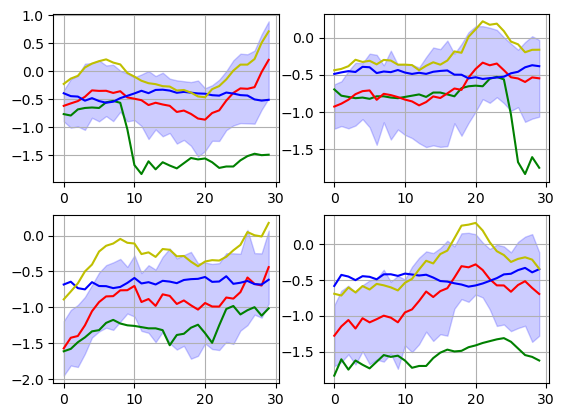

((0.32233885, 0.18983968), 0.18466213, 0.42972332, (0.13373438, 0.7795511), 15.386992, 0, 0.38105131190738656, (2432, 30))
Index:0,CRPS_L:1,AVE:0.24062626,var:0.0
Index:0,MSE_L:1,AVE:0.18466213,var:0.0
Index:0,MAE_L:1,AVE:0.25608927,var:0.0043890076
Use GPU: cuda:0
Num_params : 3432394 
>>>>>>>start training : id0_mNRU_RBN_dETTh1_ftMS_sl91_ll90_pl30_dm256_df256_ebtimeF_0_lossreg_True>>>>>>>>>>>>>>>>>>>>>>>>>>
train 12074
val 2493
test 2493
load: id0_mNRU_RBN_dETTh1_ftMS_sl91_ll90_pl30_dm256_df256_ebtimeF_0_lossreg_True


100%|██████████| 94/94 [00:50<00:00,  1.88it/s]


Epoch: 1 cost time: 50.10251426696777


100%|██████████| 19/19 [00:05<00:00,  3.33it/s]


vali_CRPS_mean:0.26088342 vali_CRPS_var:1.1726193e-05


100%|██████████| 19/19 [00:05<00:00,  3.40it/s]


test_CRPS_mean:0.35135034 test_CRPS_var:0.002957074
Epoch: 1, Steps: 94 | Train Loss: 0.4958767 Vali Loss: 0.4149273 Test Loss: -0.2377564
Validation loss decreased (inf --> 0.414927).  Saving model ...


100%|██████████| 94/94 [00:51<00:00,  1.84it/s]


Epoch: 2 cost time: 51.09541320800781


100%|██████████| 19/19 [00:05<00:00,  3.39it/s]


vali_CRPS_mean:0.26628974 vali_CRPS_var:5.8739975e-06


100%|██████████| 19/19 [00:05<00:00,  3.47it/s]


test_CRPS_mean:0.36896458 test_CRPS_var:0.004569891
Epoch: 2, Steps: 94 | Train Loss: -1.2100315 Vali Loss: -0.3364107 Test Loss: -0.7720602
Validation loss decreased (0.414927 --> -0.336411).  Saving model ...


100%|██████████| 94/94 [00:51<00:00,  1.81it/s]


Epoch: 3 cost time: 51.91358280181885


100%|██████████| 19/19 [00:05<00:00,  3.44it/s]


vali_CRPS_mean:0.2647812 vali_CRPS_var:2.4182807e-05


100%|██████████| 19/19 [00:05<00:00,  3.39it/s]


test_CRPS_mean:0.27890626 test_CRPS_var:0.0010659778
Epoch: 3, Steps: 94 | Train Loss: -1.3872363 Vali Loss: -0.2906491 Test Loss: -0.5718712
EarlyStopping counter: 1 out of 2


100%|██████████| 94/94 [00:51<00:00,  1.82it/s]


Epoch: 4 cost time: 51.7107572555542


100%|██████████| 19/19 [00:05<00:00,  3.38it/s]


vali_CRPS_mean:0.23668472 vali_CRPS_var:2.9812016e-05


100%|██████████| 19/19 [00:05<00:00,  3.49it/s]


test_CRPS_mean:0.25439355 test_CRPS_var:0.001216641
Epoch: 4, Steps: 94 | Train Loss: -1.5254808 Vali Loss: -0.8722871 Test Loss: -1.0080126
Validation loss decreased (-0.336411 --> -0.872287).  Saving model ...


100%|██████████| 94/94 [00:50<00:00,  1.85it/s]


Epoch: 5 cost time: 50.846434593200684


100%|██████████| 19/19 [00:05<00:00,  3.43it/s]


vali_CRPS_mean:0.31889716 vali_CRPS_var:0.00015739026


100%|██████████| 19/19 [00:05<00:00,  3.43it/s]


test_CRPS_mean:0.2522205 test_CRPS_var:0.0036743935
Epoch: 5, Steps: 94 | Train Loss: -1.5958525 Vali Loss: -0.5687603 Test Loss: -0.6369104
EarlyStopping counter: 1 out of 2


100%|██████████| 94/94 [00:51<00:00,  1.81it/s]


Epoch: 6 cost time: 51.87490749359131


100%|██████████| 19/19 [00:05<00:00,  3.35it/s]


vali_CRPS_mean:0.38937932 vali_CRPS_var:0.00027374204


100%|██████████| 19/19 [00:05<00:00,  3.51it/s]


test_CRPS_mean:0.24874754 test_CRPS_var:0.008678981
Epoch: 6, Steps: 94 | Train Loss: -1.6419269 Vali Loss: -0.8588017 Test Loss: -0.9683137
EarlyStopping counter: 2 out of 2
Early stopping
>>>>>>>testing : id0_mNRU_RBN_dETTh1_ftMS_sl91_ll90_pl30_dm256_df256_ebtimeF_0_lossreg_True<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
test 2493


100%|██████████| 19/19 [00:05<00:00,  3.47it/s]


test_CRPS_mean:0.25430766 test_CRPS_var:0.0012163654


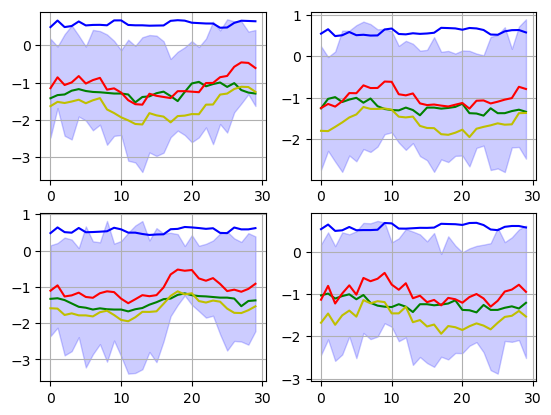

((0.31735966, 0.14401062), 0.15926051, 0.39907455, (0.31687447, 1.9356657), 78.361755, 0, 0.39336229267102796, (2432, 30))
Index:0,CRPS_L:2,AVE:0.24746695,var:8.725585e-06
Index:0,MSE_L:2,AVE:0.17196132,var:0.0001613106
Index:0,MAE_L:2,AVE:0.2433872,var:0.0061120824
Use GPU: cuda:0
Num_params : 3432394 
>>>>>>>start training : id0_mNRU_RBN_dETTh1_ftMS_sl91_ll90_pl30_dm256_df256_ebtimeF_0_lossreg_True>>>>>>>>>>>>>>>>>>>>>>>>>>
train 12074
val 2493
test 2493
load: id0_mNRU_RBN_dETTh1_ftMS_sl91_ll90_pl30_dm256_df256_ebtimeF_0_lossreg_True


100%|██████████| 94/94 [00:51<00:00,  1.83it/s]


Epoch: 1 cost time: 51.266663789749146


100%|██████████| 19/19 [00:05<00:00,  3.33it/s]


vali_CRPS_mean:0.44912323 vali_CRPS_var:0.000382974


100%|██████████| 19/19 [00:05<00:00,  3.34it/s]


test_CRPS_mean:0.31633228 test_CRPS_var:0.019050902
Epoch: 1, Steps: 94 | Train Loss: 1.1276373 Vali Loss: -0.1415826 Test Loss: -0.1918152
Validation loss decreased (inf --> -0.141583).  Saving model ...


100%|██████████| 94/94 [00:51<00:00,  1.83it/s]


Epoch: 2 cost time: 51.38893795013428


100%|██████████| 19/19 [00:05<00:00,  3.39it/s]


vali_CRPS_mean:0.41981125 vali_CRPS_var:0.00034878126


100%|██████████| 19/19 [00:05<00:00,  3.44it/s]


test_CRPS_mean:0.2711442 test_CRPS_var:0.008136086
Epoch: 2, Steps: 94 | Train Loss: -1.0898361 Vali Loss: -0.6049860 Test Loss: -0.6992004
Validation loss decreased (-0.141583 --> -0.604986).  Saving model ...


100%|██████████| 94/94 [00:50<00:00,  1.85it/s]


Epoch: 3 cost time: 50.80061340332031


100%|██████████| 19/19 [00:05<00:00,  3.46it/s]


vali_CRPS_mean:0.3434414 vali_CRPS_var:0.00025478296


100%|██████████| 19/19 [00:05<00:00,  3.41it/s]


test_CRPS_mean:0.25488815 test_CRPS_var:0.007396888
Epoch: 3, Steps: 94 | Train Loss: -1.6201465 Vali Loss: -1.1187822 Test Loss: -1.0731325
Validation loss decreased (-0.604986 --> -1.118782).  Saving model ...


100%|██████████| 94/94 [00:50<00:00,  1.85it/s]


Epoch: 4 cost time: 50.810746908187866


100%|██████████| 19/19 [00:05<00:00,  3.41it/s]


vali_CRPS_mean:0.23622262 vali_CRPS_var:7.0935006e-05


100%|██████████| 19/19 [00:05<00:00,  3.37it/s]


test_CRPS_mean:0.2074834 test_CRPS_var:0.00381957
Epoch: 4, Steps: 94 | Train Loss: -1.6416463 Vali Loss: 2.6599306 Test Loss: 2.0458347
EarlyStopping counter: 1 out of 2


100%|██████████| 94/94 [00:52<00:00,  1.81it/s]


Epoch: 5 cost time: 52.04940366744995


100%|██████████| 19/19 [00:05<00:00,  3.34it/s]


vali_CRPS_mean:0.41167986 vali_CRPS_var:0.00024631814


100%|██████████| 19/19 [00:05<00:00,  3.48it/s]


test_CRPS_mean:0.27440456 test_CRPS_var:0.011903894
Epoch: 5, Steps: 94 | Train Loss: -1.5032632 Vali Loss: -1.1372990 Test Loss: -1.1725910
Validation loss decreased (-1.118782 --> -1.137299).  Saving model ...


100%|██████████| 94/94 [00:50<00:00,  1.85it/s]


Epoch: 6 cost time: 50.805752992630005


100%|██████████| 19/19 [00:05<00:00,  3.40it/s]


vali_CRPS_mean:0.32226515 vali_CRPS_var:0.0005515284


100%|██████████| 19/19 [00:05<00:00,  3.46it/s]


test_CRPS_mean:0.26688042 test_CRPS_var:0.010344152
Epoch: 6, Steps: 94 | Train Loss: -1.9469155 Vali Loss: -1.1357194 Test Loss: -1.1087183
EarlyStopping counter: 1 out of 2


100%|██████████| 94/94 [00:50<00:00,  1.87it/s]


Epoch: 7 cost time: 50.35727596282959


100%|██████████| 19/19 [00:05<00:00,  3.39it/s]


vali_CRPS_mean:0.44243842 vali_CRPS_var:0.000322436


100%|██████████| 19/19 [00:05<00:00,  3.33it/s]


test_CRPS_mean:0.29671946 test_CRPS_var:0.01212054
Epoch: 7, Steps: 94 | Train Loss: -1.9855132 Vali Loss: -1.2107850 Test Loss: -1.1578696
Validation loss decreased (-1.137299 --> -1.210785).  Saving model ...


100%|██████████| 94/94 [00:50<00:00,  1.85it/s]


Epoch: 8 cost time: 50.93925356864929


100%|██████████| 19/19 [00:05<00:00,  3.41it/s]


vali_CRPS_mean:0.40558863 vali_CRPS_var:0.00041486882


100%|██████████| 19/19 [00:05<00:00,  3.47it/s]


test_CRPS_mean:0.2773467 test_CRPS_var:0.009757605
Epoch: 8, Steps: 94 | Train Loss: -1.8674464 Vali Loss: -0.7371818 Test Loss: -0.8943585
EarlyStopping counter: 1 out of 2


100%|██████████| 94/94 [00:51<00:00,  1.81it/s]


Epoch: 9 cost time: 51.84492540359497


100%|██████████| 19/19 [00:05<00:00,  3.42it/s]


vali_CRPS_mean:0.42332846 vali_CRPS_var:0.0004130778


100%|██████████| 19/19 [00:05<00:00,  3.37it/s]


test_CRPS_mean:0.28275976 test_CRPS_var:0.009226545
Epoch: 9, Steps: 94 | Train Loss: -2.0878778 Vali Loss: -1.1499772 Test Loss: -1.1656934
EarlyStopping counter: 2 out of 2
Early stopping
>>>>>>>testing : id0_mNRU_RBN_dETTh1_ftMS_sl91_ll90_pl30_dm256_df256_ebtimeF_0_lossreg_True<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
test 2493


100%|██████████| 19/19 [00:05<00:00,  3.47it/s]


test_CRPS_mean:0.2969029 test_CRPS_var:0.012109452


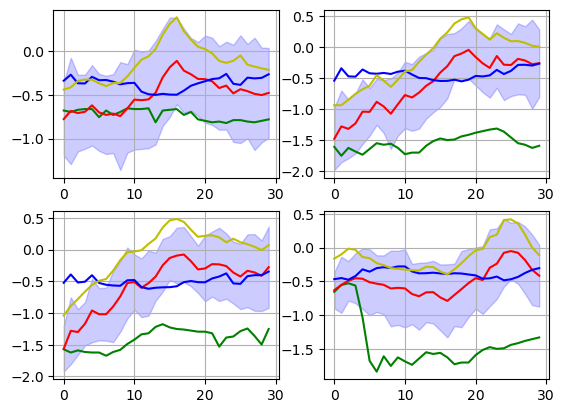

((0.3899819, 0.21658029), 0.25009844, 0.5000984, (0.17785488, 1.1296993), 26.225105, 0, 0.36930815601410233, (2432, 30))
Index:0,CRPS_L:3,AVE:0.2639456,var:1.982384e-05
Index:0,MSE_L:3,AVE:0.19800703,var:0.001464298
Index:0,MAE_L:3,AVE:0.26335183,var:0.0073775705


In [4]:
#test&train
torch.cuda.empty_cache()

mape_list=[]

mae_list=[]
rmse_list=[]
dtw_list=[]
res_list=[]
shape_list=[]
corr_list=[]
crps_list=[]
mse_list=[]
crps_varlist=[]

Exp = Exp_NRU_RBN
def runtrain(index,args):
    for ii in range(args.itr):
            # setting record of experiments
            setting = 'id{}_m{}_d{}_ft{}_sl{}_ll{}_pl{}_dm{}_df{}_eb{}_{}_lossreg_{}'.format(
                    index,args.model, args.data, args.features,args.seq_len, args.label_len, args.pred_len,
                    args.d_model, args.d_ff, 
                    args.embed, 0,str(args.lossregularizer))

            exp = Exp(args) # set experiments
            print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
        
            exp.train(setting)
            print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
            
            resultout,_ ,_,crpsret=exp.test(setting,False)
            mae, mse, rmse, mape,_, dtw,corr,shapeval =resultout
            attns=0
            mse_list.append(mse)
            mse_np=np.array(mse_list)
            mae_list.append(mae)
            mae_np=np.array(mae_list)
            crps_list.append(np.mean(crpsret))
            crps_varlist.append(np.var(crpsret))
            crps_np=np.array(crps_list)
            crps_varlist_np=np.array(crps_varlist)
            print("Index:"+str(index)+",CRPS_L:"+str(len(crps_np))+",AVE:"+str(np.mean(crps_np))+",var:"+str(np.var(crps_varlist_np)))
            print("Index:"+str(index)+",MSE_L:"+str(len(mse_np))+",AVE:"+str(np.mean(mse_np))+",var:"+str(np.var(mse_np)))
            print("Index:"+str(index)+",MAE_L:"+str(len(mae_np))+",AVE:"+str(np.mean(mae_np))+",var:"+str(np.var(mae_np)))
            
            torch.cuda.empty_cache()

if args.data_path == 'electrans.csv' or args.data_path == 'exchange.csv':
        df_raw = pd.read_csv(os.path.join(args.root_path,
                                          args.data+"_all.csv")).set_index('date')
        t,c=df_raw.shape
        for index in range(c):
                print("Index: ", index)
                df_use = df_raw.iloc[:,index]
                path = "datasets/"+args.data+".csv"
                df_use.to_csv(path)
                runtrain(index,args)
else:
        runtrain(0,args)

Use GPU: cuda:0
Num_params : 3432394 
>>>>>>>testing : id0_mNRU_RBN_dETTh1_ftMS_sl91_ll90_pl30_dm256_df256_ebtimeF_0_lossreg_True<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
test 2493
load: id0_mNRU_RBN_dETTh1_ftMS_sl91_ll90_pl30_dm256_df256_ebtimeF_0_lossreg_True


100%|██████████| 19/19 [00:05<00:00,  3.48it/s]


test_CRPS_mean:0.29675853 test_CRPS_var:0.012157244


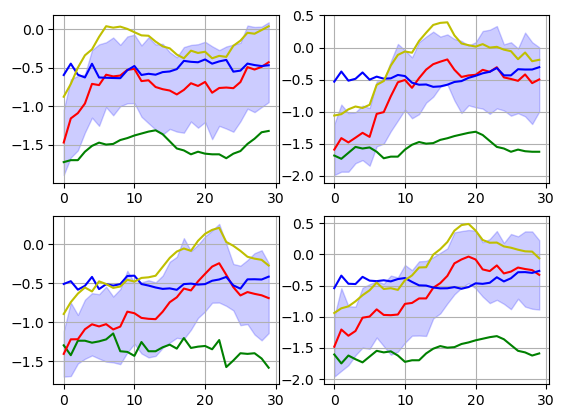

((0.3897992, 0.21680309), 0.25000963, 0.5000096, (0.17591943, 1.1231673), 25.805235, 0, 0.3696021271203089, (2432, 30))
Index:0,CRPS_L:1,AVE:0.29675853,var:0.0
Index:0,MSE_L:1,AVE:0.25000963,var:0.0
Index:0,MAE_L:1,AVE:0.30330116,var:0.007481914


In [5]:
#
#test

mape_list=[]

mae_list=[]
rmse_list=[]
dtw_list=[]
res_list=[]
shape_list=[]
corr_list=[]
crps_list=[]
mse_list=[]
crps_varlist=[]

Exp = Exp_NRU_RBN
def runtrain(index,args):
    
    setting = 'id{}_m{}_d{}_ft{}_sl{}_ll{}_pl{}_dm{}_df{}_eb{}_{}_lossreg_{}'.format(
                    index,args.model, args.data, args.features,args.seq_len, args.label_len, args.pred_len,
                    args.d_model, args.d_ff, 
                    args.embed, 0,str(args.lossregularizer))
    exp = Exp(args)
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    resultout,_ ,_,crpsret=exp.test(setting,True)
    mae, mse, rmse, mape,_, dtw,corr,shapeval =resultout
    attns=0
    """if args.do_predict:
        print('>>>>>>>predicting : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
        exp.predict(setting, True)"""

    torch.cuda.empty_cache()
    return crpsret,mae, mse, rmse, mape,_, dtw,corr,shapeval


if args.data_path == 'electrans.csv'or args.data_path == 'exchange.csv':
        df_raw = pd.read_csv(os.path.join(args.root_path,
                                          args.data+"_all.csv")).set_index('date')
        t,c=df_raw.shape
        for index in range(0, c):
                print("Index: ", index)
                df_use = df_raw.iloc[:,index]
                path = "datasets/"+args.data+".csv"
                df_use.to_csv(path)
                crpsret,mae, mse, rmse, mape,_, dtw,corr,shapeval=runtrain(index,args)
                mse_list.append(mse)
                mse_np=np.array(mse_list)
                mae_list.append(mae)
                mae_np=np.array(mae_list)
                crps_list.append(np.mean(crpsret))
                crps_varlist.append(np.var(crpsret))
                crps_np=np.array(crps_list)
                crps_varlist_np=np.array(crps_varlist)
                print("Index:"+str(index)+",CRPS_L:"+str(len(crps_np))+",AVE:"+str(np.mean(crps_np))+",var:"+str(np.var(crps_varlist_np)))
                print("Index:"+str(index)+",MSE_L:"+str(len(mse_np))+",AVE:"+str(np.mean(mse_np))+",var:"+str(np.var(mse_np)))
                print("Index:"+str(index)+",MAE_L:"+str(len(mae_np))+",AVE:"+str(np.mean(mae_np))+",var:"+str(np.var(mae_np)))

else:
        crpsret,mae, mse, rmse, mape,_, dtw,corr,shapeval=runtrain(0,args)
        mse_list.append(mse)
        mse_np=np.array(mse_list)
        mae_list.append(mae)
        mae_np=np.array(mae_list)
        crps_list.append(np.mean(crpsret))
        crps_varlist.append(np.var(crpsret))
        crps_np=np.array(crps_list)
        crps_varlist_np=np.array(crps_varlist)
        print("Index:"+str(0)+",CRPS_L:"+str(len(crps_np))+",AVE:"+str(np.mean(crps_np))+",var:"+str(np.var(crps_varlist_np)))
        print("Index:"+str(0)+",MSE_L:"+str(len(mse_np))+",AVE:"+str(np.mean(mse_np))+",var:"+str(np.var(mse_np)))
        print("Index:"+str(0)+",MAE_L:"+str(len(mae_np))+",AVE:"+str(np.mean(mae_np))+",var:"+str(np.var(mae_np)))


